In [1]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = (
    boston_housing.load_data())

57026/57026 [==============================] - 0s 0us/step


We don't have a very big dataset here... it's just 506 rows, total, 13 features.

In [2]:
print("Train data dimensions:",train_data.shape)
print("Test data dimensions:",test_data.shape)
print(train_targets) # these are home prices in $1,000s of dollars (in the 70s that was a lot of money)

Train data dimensions: (404, 13)
Test data dimensions: (102, 13)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3 

Let's 'whiten' the data...

In [3]:
# We can whiten the data like this; or we can use the np.mean(), np.sub(), and np.divide() functions.
mean_train = train_data.mean(axis=0)
train_data -= mean_train
std_train = train_data.std(axis=0)
train_data /= std_train

#fix to subtract test mean...
mean_test = test_data.mean(axis=0)
test_data -= mean_test
std_test = test_data.std(axis=0)
test_data /= std_test

And, let's define our simple network. We are going to define a simple function that re-specifies our model and compiles it. We're doing this because we will use this inside a nested loop that implements k-fold cross-validation. This is something you've probably already learned in other classes, but when your sample is small, it's generally not a good idea to rely on single random holdout for model evaluation. 

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
    model = keras.Sequential([
        layers.Dropout(rate=0.5),
        layers.BatchNormalization(), # This whitens the inputs to the next layer (de-mean, divide by SD, which can help with training)
        layers.Dense(8, activation="relu"),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(4, activation="relu"),
        layers.Dense(1)
    ])

    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

    return model

The example code from the book breaks up the training sample into k folds, and cycles over each, leveraging the *other* k-1 folds for training, and using the focal fold evaluation. We store the average validation error metric across the k runs. We can repeat this process using different numbers of epochs, batch sizes, etc. Eventually, when we settle on a model that looks good, we do a final evaluation on the test data.  

In [5]:
import numpy as np

k = 4 
num_val_samples = len(train_data) // k # floor division (i.e., round down to nearest integer.)
num_epochs = 500
all_mae_histories = []  

print("In total, we have",len(train_data),"training observations.")
print("With a k of",k,"we have",num_val_samples,"observations per fold.\n")

for i in range(k): # the folds are going to be indexed 0 through 3 if k = 4
    print("Processing fold #:",i)
    # if I slice past the end of the array, it just gives me what it can find! No errors.
    # This is important here, because the last fold won't produce an error, despite our slice going well beyond the end of the array.
    print("Validation data includes observations",i*num_val_samples,"through",(i+1)*num_val_samples-1) # minus 1 because a slice is up to and not including the second index.
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    print("Training data includes observations 0 through",i*num_val_samples,"joined with observations",(i+1)*num_val_samples,"through the final observation.\n")
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=1)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

In total, we have 404 training observations.
With a k of 4 we have 101 observations per fold.

Processing fold #: 0
Validation data includes observations 0 through 100
Training data includes observations 0 through 0 joined with observations 101 through the final observation.

Epoch 1/500
19/19 [==============================] - 7s 16ms/step - loss: 573.1940 - mae: 22.1546 - val_loss: 565.5361 - val_mae: 21.6365
Epoch 2/500
19/19 [==============================] - 0s 6ms/step - loss: 564.8768 - mae: 21.9754 - val_loss: 560.9335 - val_mae: 21.5221
Epoch 3/500
19/19 [==============================] - 0s 5ms/step - loss: 560.1370 - mae: 21.8422 - val_loss: 556.2429 - val_mae: 21.4117
Epoch 4/500
19/19 [==============================] - 0s 5ms/step - loss: 553.9095 - mae: 21.7216 - val_loss: 551.1266 - val_mae: 21.2863
Epoch 5/500
19/19 [==============================] - 0s 6ms/step - loss: 542.1632 - mae: 21.4663 - val_loss: 544.9775 - val_mae: 21.1341
Epoch 6/500
19/19 [==================

Now we can calculate the average MAE in each epoch, across the 4 iterations. That is, for epoch 1, take the average MAE over the 4 iterations, then do it again for epoch 2, and so on. We will end up with 500 averages.

*Q: Can you explain what this code does, exactly?*

In [ ]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
len(average_mae_history)

500

And now we plot them.

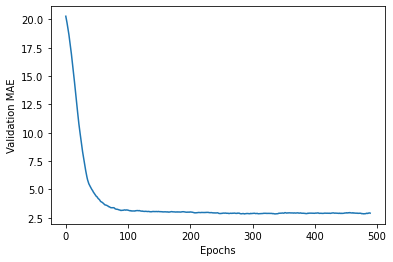

In [ ]:
import matplotlib.pyplot as plt

plt.plot(average_mae_history[10:])
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

Now we fit a final model and evaluate its performance on the test data. Being off by ~$2,500 in 70's dollars is a lot actually. Our model isn't that great. 

In [ ]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=150, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 6ms/step - loss: 21.8853 - mae: 3.2861


And of course, this is how we obtain predictions from the model. 

In [ ]:
predictions = model.predict(test_data)
print(predictions)

[[11.951524]
 [18.801569]
 [20.710611]
 [30.624788]
 [22.6381  ]
 [19.698586]
 [27.686562]
 [22.786911]
 [18.71872 ]
 [19.801027]
 [19.03137 ]
 [18.964584]
 [17.474918]
 [36.08865 ]
 [16.200592]
 [20.864317]
 [24.0487  ]
 [21.918776]
 [17.548767]
 [22.893604]
 [15.057753]
 [16.40392 ]
 [20.086412]
 [18.632032]
 [21.41848 ]
 [21.192839]
 [28.867472]
 [26.801498]
 [14.608603]
 [20.828955]
 [20.48301 ]
 [16.333176]
 [32.19738 ]
 [22.858168]
 [17.32572 ]
 [11.793835]
 [18.569044]
 [21.077272]
 [17.776754]
 [26.367458]
 [26.005018]
 [26.701067]
 [16.297033]
 [36.363796]
 [27.169868]
 [21.76534 ]
 [25.43458 ]
 [18.7181  ]
 [20.924116]
 [21.99487 ]
 [29.7787  ]
 [19.834623]
 [14.766367]
 [18.434189]
 [32.713573]
 [25.639847]
 [16.422142]
 [40.737583]
 [32.943817]
 [23.107456]
 [23.47957 ]
 [17.618868]
 [17.170263]
 [19.69501 ]
 [23.54989 ]
 [23.35356 ]
 [16.122013]
 [24.046019]
 [15.320637]
 [11.531606]
 [22.835558]
 [27.407398]
 [18.89802 ]
 [15.711417]
 [25.113983]
 [21.097034]
 [20.541386]